# Geospatial Analysis of Water Pumps Data

In [23]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
#import mapclassify

In [21]:
df_training = pd.read_csv("../data/processed/lat_lon_imputed.csv") 
# df_test = pd.read_csv("data/raw/TestSetValues.csv")

In [22]:
df_training.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [3]:
df_training.shape

(59400, 41)

## Geographical Data Exploration

**1. Load District Shapefile**

In [ ]:
# Load districts of Tanzania (level 2)
districts = gpd.read_file("../data/external/gadm41_TZA_shp/gadm41_TZA_2.shp")

# Preview the data
print(districts.columns)
print(districts.head())

**2. Convert Pump Dataset**

In [26]:
from shapely.geometry import Point

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(df_training.longitude, df_training.latitude)]
df_pumps = gpd.GeoDataFrame(df_training, geometry=geometry, crs="EPSG:4326")

**3. Spatial Join Pumps with Districts**

 To tell a GIS software or code how to interpret the geographic coordinates (like longitude and latitude) in the data, CRS is used. CRS stands for Coordinate Reference System.

**Accurate Distance & Area Calculations**
- Geographic coordinates (latitude/longitude) aren’t measured in meters — they’re angular degrees.
- To calculate real-world distances or areas, you need to project them into a metric system.
**Spatial Operations Compatibility**
When doing overlays, spatial joins, or distance calculations, all layers must be in the same CRS.

Types of CRS:
**Geographic CRS (GCS)** – based on degrees
Example: EPSG:4326
- The standard GPS system (WGS84)
- Coordinates in latitude/longitude
- Good for maps, not for distance calculations

**Projected CRS** – based on meters
Example: EPSG:3857 (Web Mercator) or EPSG:21037 (UTM zone for Tanzania)
- Coordinates in meters
- Needed for distance, buffer, area, etc.

In [27]:
# Make sure CRS matches
df_pumps = df_pumps.to_crs(districts.crs)

# Spatial join to add district info from shapefile
pumps_with_district = gpd.sjoin(df_pumps, districts, how="left", predicate="within")

# Check if join worked
print(pumps_with_district[['extraction_type', 'NAME_1', 'NAME_2','district_code','lga','ward']].head())

  extraction_type   NAME_1     NAME_2  district_code        lga        ward
0         gravity   Njombe     Ludewa              5     Ludewa    Mundindi
1         gravity     Mara  Serengeti              2  Serengeti       Natta
2         gravity  Manyara  Simanjiro              4  Simanjiro     Ngorika
3     submersible   Mtwara   Nanyumbu             63   Nanyumbu    Nanyumbu
4         gravity   Kagera    Karagwe              1    Karagwe  Nyakasimbi


**Option 1: Plot All Pumps Colored by Type**

In [ ]:

fig, ax = plt.subplots(figsize=(8, 8))
districts.plot(ax=ax, color='lightgrey', edgecolor='black')
pumps_with_district.plot(ax=ax, column='extraction_type', markersize=5, legend=True)
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.8, 0.7))

plt.title("Water Pump Extraction Types in Tanzania")
plt.axis("off")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
districts.plot(ax=ax, color='lightgrey', edgecolor='black')
pumps_with_district.plot(ax=ax, column='extraction_type_group', markersize=5, legend=True)
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.8, 0.8))

plt.title("Water Pump Extraction Types Groups in Tanzania")
plt.axis("off")
plt.show()

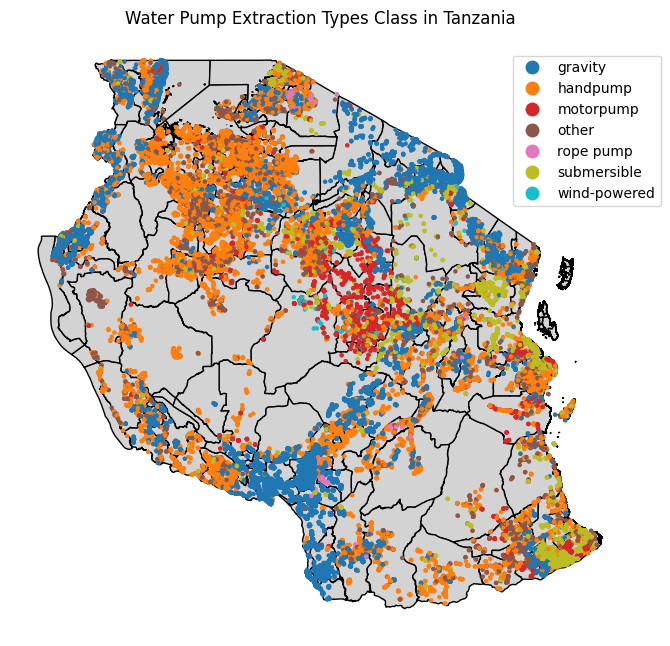

In [37]:

fig, ax = plt.subplots(figsize=(8, 8))
districts.plot(ax=ax, color='lightgrey', edgecolor='black')
pumps_with_district.plot(ax=ax, column='extraction_type_class', markersize=5, legend=True)
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.8, 0.7))

plt.title("Water Pump Extraction Types Class in Tanzania")
plt.axis("off")
plt.show()

**Option 2: Aggregate by District and Plot Counts**

In [ ]:
# Count pumps by district and type
summary = pumps_with_district.groupby(['NAME_2', 'extraction_type_class']).size().unstack(fill_value=0)

# Optionally normalize or highlight top types
summary['dominant_type'] = summary.idxmax(axis=1)

# Merge back into districts
districts_summary = districts.merge(summary['dominant_type'], left_on='NAME_2', right_index=True)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
districts_summary.plot(column='dominant_type', ax=ax, legend=True, cmap='Set3', edgecolor='black')
plt.title("Most Common Water Pump Type per District in Tanzania")
plt.axis("off")
plt.show()

**Pumps Based on Functional Status:**

Perform a Spatial Join (Pumps with Districts)

Next, we’ll join the pump data with the district polygons from the shapefile. This will assign each pump to its respective district.

In [40]:
# Make sure both dataframes use the same CRS
df_pumps = df_pumps.to_crs(districts.crs)

# Spatial join: Attach district information to the pumps
pumps_with_district = gpd.sjoin(df_pumps, districts, how="left", predicate="within")

# Check if the join worked (you should see district info alongside pump data)
print(pumps_with_district[['status_group', 'NAME_2']].head())

     status_group     NAME_2
0      functional     Ludewa
1      functional  Serengeti
2      functional  Simanjiro
3  non functional   Nanyumbu
4      functional    Karagwe


**Plot Pumps Colored by Functional Status**

Now, let’s plot the pumps on a map and color them by their functional status (based on the status_group column).

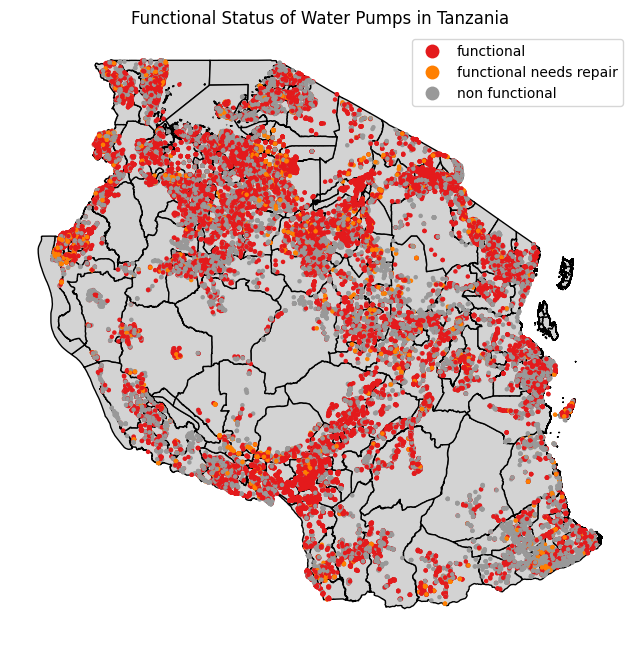

In [41]:
import matplotlib.pyplot as plt

# Create a map plot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the districts (background map)
districts.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot the pumps, color by functional status
pumps_with_district.plot(ax=ax, column='status_group', markersize=5, legend=True, cmap='Set1')

# Add a title
plt.title("Functional Status of Water Pumps in Tanzania")
plt.axis("off")  # Hide axes
plt.show()

**Option to Aggregate by District (and Visualize)**

If you'd like to show the functional status aggregated at the district level (i.e., the proportion of functional, non-functional, etc. pumps per district), follow this approach:

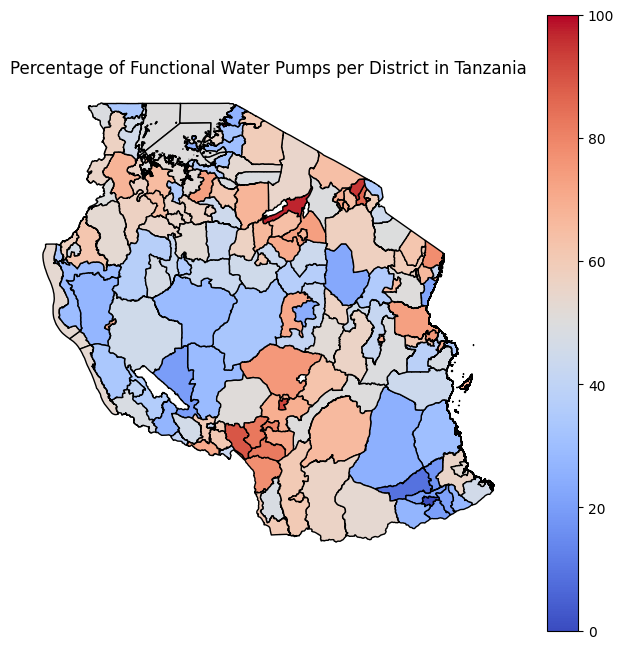

In [42]:
# Count pumps per district and status group
status_counts = pumps_with_district.groupby(['NAME_2', 'status_group']).size().unstack(fill_value=0)

# You could normalize or analyze the data (e.g., percentage of functional pumps per district)
status_counts['functional_percentage'] = (status_counts['functional'] / status_counts.sum(axis=1)) * 100

# Merge the status counts back into the districts GeoDataFrame
districts_status = districts.merge(status_counts['functional_percentage'], left_on='NAME_2', right_index=True)

# Plot the districts, color by the percentage of functional pumps
fig, ax = plt.subplots(figsize=(8, 8))
districts_status.plot(column='functional_percentage', ax=ax, legend=True, cmap='coolwarm', edgecolor='black')

plt.title("Percentage of Functional Water Pumps per District in Tanzania")
plt.axis("off")
plt.show()


**Filter and Map Pumps by Basin (River)**

Adding rivers or water sources to the map can help you visualize whether water availability or proximity to rivers correlates with the functional status of water pumps. You can overlay river data (e.g., from OpenStreetMap or other sources) along with your existing district and pump data.

Now, we will filter pumps based on the basin (river) name and plot them, while coloring the pumps based on their functional status.

In [ ]:
# Create the plot
fig, ax = plt.subplots(figsize=(8,12))

# Plot the districts (background)
districts.plot(ax=ax, color='lightgrey', edgecolor='black')

# Define a list of unique basins (rivers) from the dataset
basins = pumps_with_district['basin'].unique()

# Iterate through each basin (river) and plot the pumps related to that river
for basin in basins:
    # Filter pumps by basin (river)
    basin_pumps = pumps_with_district[pumps_with_district['basin'] == basin]
    
    # Plot pumps, color by functional status
    basin_pumps.plot(ax=ax, column='status_group', markersize=5, legend=True, cmap='Set1', label=basin)

# Add title and customize the plot
plt.title("Water Pumps by Basin and Functional Status in Tanzania")
plt.axis("off")  # Hide axis for clarity
plt.legend(title="Basin (River) / Functional Status", loc='upper right')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.0, 1.0))
plt.show()


**Proximity Analysis**

Analyze whether water pumps are more functional near specific rivers by filtering based on the basin name and comparing the functionality:

In [49]:
# Group by basin and status to see the distribution
basin_status_summary = pumps_with_district.groupby(['basin', 'status_group']).size().unstack(fill_value=0)

print(basin_status_summary)

status_group             functional  functional needs repair  non functional
basin                                                                       
Internal                       4482                      557            2746
Lake Nyasa                     3324                      250            1511
Lake Rukwa                     1000                      270            1184
Lake Tanganyika                3107                      742            2583
Lake Victoria                  5100                      989            4159
Pangani                        5372                      477            3091
Rufiji                         5068                      437            2471
Ruvuma / Southern Coast        1670                      326            2497
Wami / Ruvu                    3136                      269            2582


## Step-by-Step: Interactive Water Pump Map in Folium

In [50]:
from folium.plugins import MarkerCluster


# Optional: drop NaNs in key columns (status_group, latitude, longitude)
fdf = df_training.dropna(subset=['latitude', 'longitude', 'status_group'])

# Set a rough center of Tanzania for map focus
tanzania_center = [-6.369028, 34.888822]


**2. Create a Folium Map**

In [51]:
# Create the base map
m = folium.Map(location=tanzania_center, zoom_start=6, tiles='cartodbpositron')

**3. Add Water Pumps as Markers with Status and Basin Info**

We use MarkerCluster to avoid clutter and popups to show info when clicked.

In [52]:
# Add marker clusters
marker_cluster = MarkerCluster().add_to(m)

# Define colors for functional status
status_colors = {
    "functional": "green",
    "non functional": "red",
    "functional needs repair": "orange"
}

# Add markers
for _, row in df_training.iterrows():
    status = row['status_group'].lower()
    color = status_colors.get(status, "gray")
    
    popup_info = f"""
    <b>Status:</b> {row['status_group']}<br>
    <b>Basin:</b> {row['basin']}<br>
    <b>Region:</b> {row['region']}<br>
    <b>District:</b> {row['lga']}
    """
    
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=4,
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=folium.Popup(popup_info, max_width=300)
    ).add_to(marker_cluster)


- Visually correlate pump distribution with administrative areas to see, for example, where most non-functional pumps are.

In [54]:
folium.GeoJson('../data/external/TZA_ADM2/TZA_ADM2.geojson', name="Districts").add_to(m)

Basemap Layer Control (folium.LayerControl): switch between different basemaps, e.g., street view, terrain, satellite.

In [55]:
folium.LayerControl().add_to(m)

Filtering by Basin or Status
create layer groups for each status (e.g., Functional, Non-functional).

In [56]:
# Example LayerGroup
functional_layer = folium.FeatureGroup(name="Functional Pumps").add_to(m)
non_functional_layer = folium.FeatureGroup(name="Non-functional Pumps").add_to(m)

**4. Show the Map in Jupyter Notebook or Save as HTML**

In [ ]:
# In Jupyter Notebook
m

# Or save to an HTML file to open in browser
#m.save("../results/tanzania_water_pumps_map.html")

**1. Setup the Base Map for Folium**

In [61]:
# Starting point centered over Tanzania
map_center = [-6.3690, 34.8888]
m = folium.Map(location=map_center, zoom_start=6, tiles='CartoDB positron')

**2. Add Colored Markers for Functional Status**

In [62]:
# Create a function to map status to color:
def status_color(status):
    if status == 'functional':
        return 'green'
    elif status == 'non functional':
        return 'red'
    elif status == 'functional needs repair':
        return 'orange'
    return 'gray'

# Add markers to the map
from folium.plugins import MarkerCluster

# Use a MarkerCluster to group dense points
marker_cluster = MarkerCluster().add_to(m)

# Loop through water pumps and add markers
for _, row in df_final.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color=status_color(row['status_group']),  # assuming column name is 'status_group'
        fill=True,
        fill_opacity=0.7,
        popup=f"Ward: {row['ward']}, Status: {row['status_group']}"
    ).add_to(marker_cluster)


**4. Add Layer Controls and Save**

In [64]:
folium.GeoJson('../data/external/TZA_ADM2/TZA_ADM2.geojson', name="Districts").add_to(m)

In [65]:
# Example LayerGroup
functional_layer = folium.FeatureGroup(name="Functional Pumps").add_to(m)
non_functional_layer = folium.FeatureGroup(name="Non-functional Pumps").add_to(m)

In [ ]:
folium.LayerControl().add_to(m)

legend_html = """
<div style="
    position: fixed;
    bottom: 30px;
    left: 30px;
    width: 170px;
    height: 120px;
    background-color: white;
    border:2px solid grey;
    z-index:9999;
    font-size:14px;
    padding: 10px;
    box-shadow: 2px 2px 5px rgba(0,0,0,0.4);
    ">
    <b>Water Pump Status</b><br>
    <i style="background:green; width:10px; height:10px; display:inline-block;"></i> Functional<br>
    <i style="background:orange; width:10px; height:10px; display:inline-block;"></i> Needs Repair<br>
    <i style="background:red; width:10px; height:10px; display:inline-block;"></i> Non-Functional<br>
</div>
"""

m.get_root().html.add_child(folium.Element(legend_html))

# Save to HTML file
#m.save("tanzania_waterpumps_map_legend.html")

m
